Test imaging of single FITS files / explore data

In [1]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.optimize import curve_fit
import glob
from astropy.time import Time
from datetime import datetime
from collections import defaultdict
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

crab_img_directories = ["../data/Crab/3-15keV/Images", "../data/Crab/15-30keV/Images", "../data/Crab/30-60keV/Images"]
crab_files = [np.sort(os.listdir(directory)) for directory in crab_img_directories]

## Crab

In [3]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra, crab_dec = crab_coords.ra.deg, crab_coords.dec.deg

/tmp/ipykernel_53247/3772676962.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


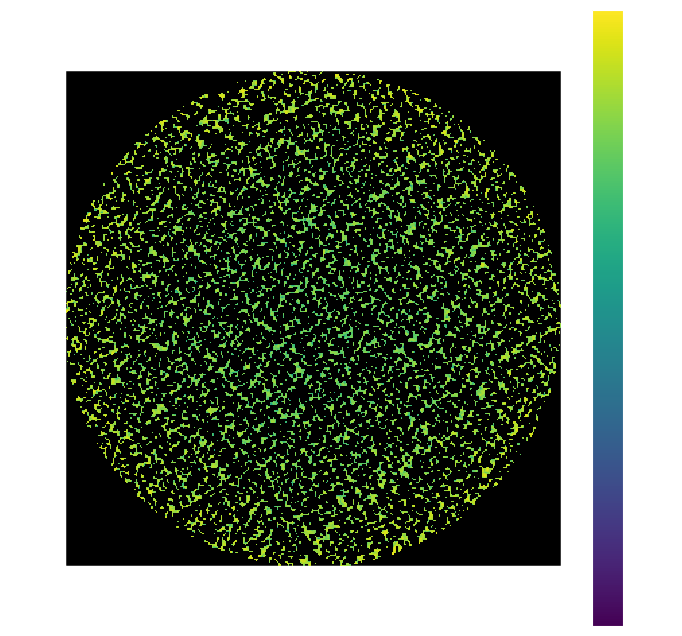

/tmp/ipykernel_53247/3772676962.py:9: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')
/tmp/ipykernel_53247/3772676962.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


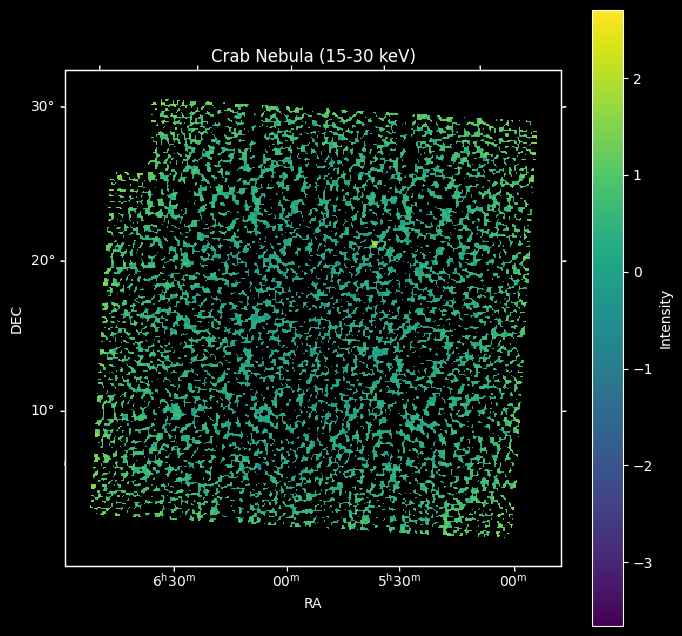

/tmp/ipykernel_53247/3772676962.py:9: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')
/tmp/ipykernel_53247/3772676962.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


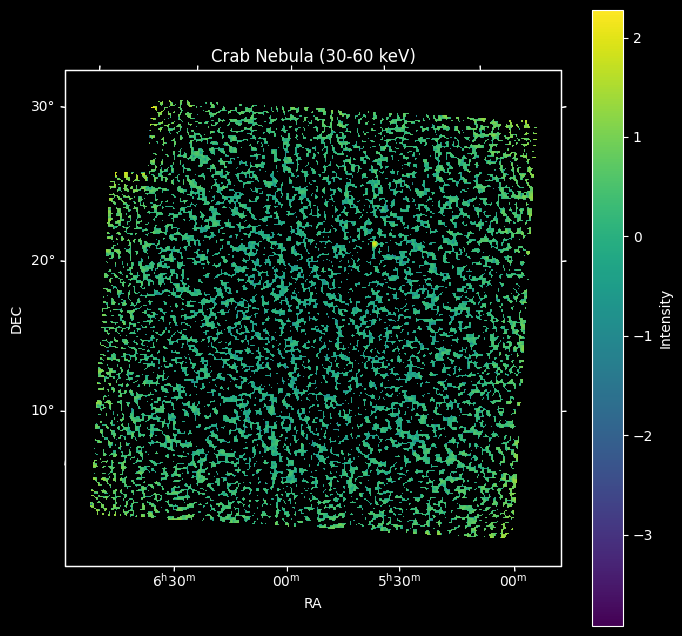

In [2]:
for i, directory in enumerate(crab_img_directories):
    with fits.open(os.path.join(directory, crab_files[i][0])) as hdu:
        crab_img = hdu[2].data
        wcs = WCS(hdu[2].header)

    fig = plt.figure(figsize=(8, 8))
    plt.style.use('dark_background')
    ax = fig.add_subplot(111, projection=wcs)  # Create a new figure for each image with WCS projection
    im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    if i == 0:
        E1, E2 = 3, 15
    elif i == 1:
        E1, E2 = 15, 30
    else:
        E1, E2 = 30, 60
    ax.set_title(f"Crab Nebula ({E1}-{E2} keV)")

    cbar = plt.colorbar(im, ax=ax, label="Intensity")
    
    plt.style.use('dark_background')
    plt.show()

Gaussian fitting

In [6]:
os.path.join(crab_img_directories[1], crab_files[0][-1])

'../data/Crab/15-30keV/Images/288500370010.001mosaic.fits'

In [4]:
with fits.open(os.path.join(crab_img_directories[1], crab_files[0][-1])) as hdu:
    crab_img = hdu[2].data
    crab_var = hdu[3].data

    wcs = WCS(hdu[2].header)
    x, y = wcs.all_world2pix(crab_ra, crab_dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))
    crab_countrate = crab_img[y_int, x_int]
    crab_variance = crab_var[y_int, x_int]
    
x = np.arange(0, crab_img.shape[1])
y = np.arange(0, crab_img.shape[0])
x, y = np.meshgrid(x, y)

def Gaussian2D_fixed(xy, amplitude, xo, yo):
    return Gaussian2D(xy, amplitude, xo, yo, np.sqrt(crab_variance), np.sqrt(crab_variance), 0, 0)

print(f"Crab single pixel count rate: {crab_countrate:.2f} +/- {np.sqrt(crab_variance):.2f}")

# Fit the data with the Gaussian2D model, fit only the amplitude and the position
from scipy.optimize import curve_fit
popt, pcov = curve_fit(Gaussian2D_fixed, (x, y), crab_img.ravel(), p0=[crab_countrate, x_int, y_int])# , sigma=np.sqrt(var_data.ravel())
popt2, pcov2 = curve_fit(Gaussian2D, (x, y), crab_img.ravel(), p0=[crab_countrate, x_int, y_int,  np.sqrt(crab_variance),  np.sqrt(crab_variance), 0, 0])
crab_psf_countrate_fixed = popt[0]
crab_psf_countrate = popt2[0]
crab_psf_error_fixed = np.sqrt(np.diag(pcov))[0]
crab_psf_error = np.sqrt(np.diag(pcov2))[0]

print(f"Crab PSF count rate using amplitude + position: {crab_psf_countrate_fixed:.2f} +/- {crab_psf_error_fixed:.2f}")
print(f"Crab PSF count rate using all parameters: {crab_psf_countrate:.2f} +/- {crab_psf_error:.2f}")


Crab single pixel count rate: 191.32 +/- 3.42
Crab PSF count rate using amplitude + position: 46.24 +/- 4.24
Crab PSF count rate using all parameters: 206.32 +/- 16.60


/tmp/ipykernel_53247/2336995581.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


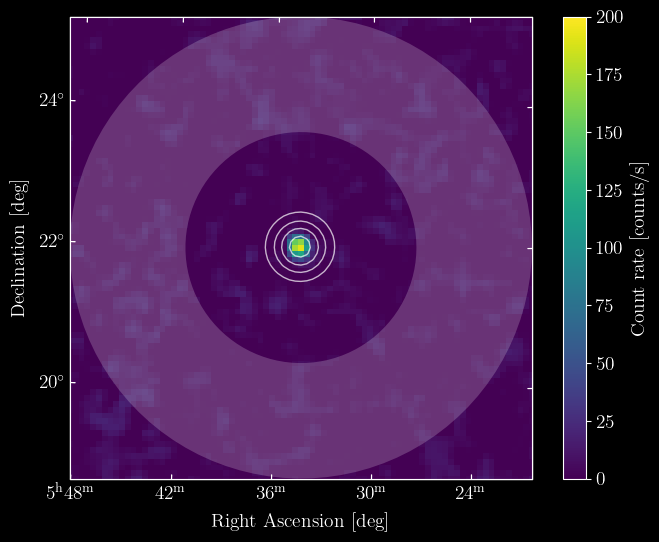

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.units as u
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=wcs)

im = ax.imshow(
    crab_img,
    cmap='viridis',
    origin='lower',
    vmin=0,
    vmax=200,
    interpolation='nearest'
)

cbar = fig.colorbar(im)
cbar.set_label(r'Count rate [counts/s]', fontsize=14)
cbar.ax.tick_params(labelsize=14)

ax.contour(
    x, y,
    Gaussian2D_fixed((x, y), *popt).reshape(crab_img.shape),
    levels=4,
    colors='white',
    linewidths=1,
    alpha=0.7
)

theta = np.linspace(0, 2 * np.pi, 100)
from matplotlib.patches import Polygon
outer_x = 40 * np.cos(theta) + x_int
outer_y = 40 * np.sin(theta) + y_int
inner_x = 20 * np.cos(theta) + x_int
inner_y = 20 * np.sin(theta) + y_int
inner_x = inner_x[::-1]
inner_y = inner_y[::-1]
x_annulus = np.concatenate([outer_x, inner_x])
y_annulus = np.concatenate([outer_y, inner_y])
annulus = np.column_stack((x_annulus, y_annulus))
annulus_patch = Polygon(annulus, closed=True, edgecolor=None, facecolor='white', alpha=0.2)
ax.add_patch(annulus_patch)

# Axes limits
ax.set_xlim(x_int - 40, x_int + 40)
ax.set_ylim(y_int - 40, y_int + 40)

# Labels
ax.set_xlabel(r'Right Ascension [deg]', fontsize=14)
ax.set_ylabel(r'Declination [deg]', fontsize=14)

plt.tick_params(which='both', labelsize=14, direction='in', color='white')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='white')
plt.tight_layout()

if True:
    plt.savefig("../data/Figures/Crab-15-30-PSF.pdf", bbox_inches='tight', dpi=300)
    plt.savefig("/mnt/c/Users/luoji/Desktop/Master EPFL/TPIVb/Figures/Crab-15-30-PSF.pdf", bbox_inches='tight', dpi=300)

FITS header exploration

In [9]:
jemx_header = fits.open(os.path.join(crab_img_directories[1], crab_files[0][0]))[2].header
jemx_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  423                                                  
NAXIS2  =                  423                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
BASETYPE= 'DAL_ARRAY'                                                           
BUNIT   = 'counts/sec'                                                          
CD1_1   =  -0.0822862539155913                                                  
CD1_2   =                  0.0                                                  
CD2_1   =                  0.0                                                  
CD2_2   =   0.08228625391559

## Jupiter

In [2]:
from astropy.io import ascii
from astropy.time import Time
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.optimize import curve_fit
import glob
from datetime import datetime
from collections import defaultdict
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

jupiter_table = ascii.read('../data/jupiter_table.dat')

jupiter_ra = jupiter_table['jupiter_ra'].data # ICRS
jupiter_dec = jupiter_table['jupiter_dec'].data

jdates = jupiter_table['start_date'].data # MJD
jdates = [Time(jd, format="mjd").datetime for jd in jdates]

jscws = [str(scw).zfill(12) for scw in jupiter_table['scw_id'].data]

In [3]:
# Angle of Jupiter's axis at time of observation (Stellarium)
angle = 3 + 28 /60 + 26 / 3600 # degrees

Observation date: 2019-02-20 06:43:12.403160


(88.35046190853166, 168.35046190853166)

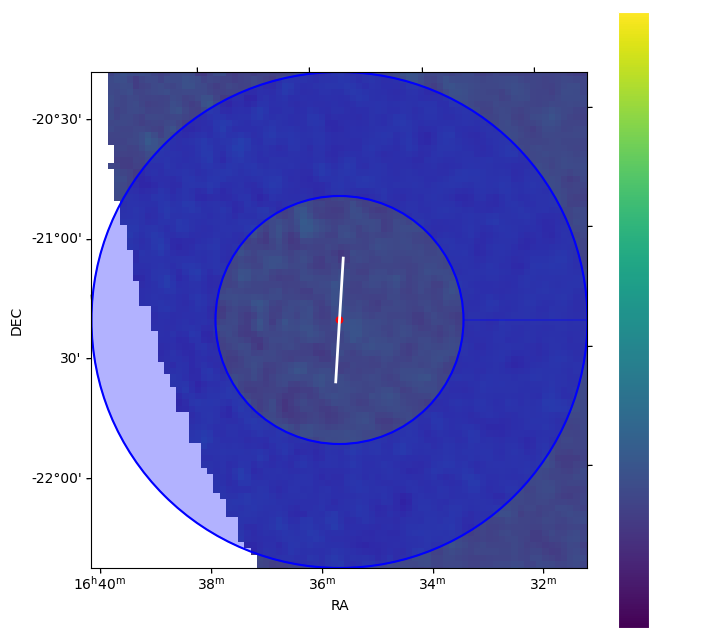

In [4]:
from astropy.wcs.utils import proj_plane_pixel_scales

new_dir = '../data/Jupiter/3-15keV/Images/'
new_files = os.listdir(new_dir)

idx = new_files.index('205900180010.001mosaic.fits') # 205900180010, 205900070010 for JEM-X, 206000380010 for ISGRI

# find date in jdates using scw_id
obs_date_idx = jscws.index('205900180010')
print(f"Observation date: {jdates[obs_date_idx]}")

with fits.open(os.path.join(new_dir, new_files[idx])) as hdu:
    j_img = hdu[2].data
    wcs = WCS(hdu[2].header)

# Get WCS pixel scale in degrees/pixel
pixel_scales = proj_plane_pixel_scales(wcs) 
mean_pixel_scale_deg = np.mean(pixel_scales) 
mean_pixel_scale_arcsec = mean_pixel_scale_deg * 3600  # arcsec/pixel

# Convert 100*Rj = 4300 arcsec to pixels
rj_arcsec = 43
radius_arcsec = 1 * rj_arcsec  # 4300 arcsec
radius_pix = radius_arcsec / mean_pixel_scale_arcsec

# SkyCoord for Jupiter
idx = jscws.index(new_files[idx][:12])
j_coord = SkyCoord(jupiter_ra[idx], jupiter_dec[idx], unit="deg")
j_x, j_y = skycoord_to_pixel(j_coord, wcs)

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=wcs)
plt.style.use('dark_background')

im = ax.imshow(j_img, cmap='viridis', origin='lower', aspect='equal')

# Circle with radius corresponding to 100*Rj
circle = Circle((j_x, j_y), radius=radius_pix, edgecolor='red', facecolor='none', linewidth=1.5)
ax.add_patch(circle)

# Annular region inner radius = 20 pixels, outer radius = 40 pixels

inner_radius = 20
outer_radius = 40
inner_circle = Circle((j_x, j_y), inner_radius, edgecolor='blue', facecolor='none', linewidth=1.5)
outer_circle = Circle((j_x, j_y), outer_radius, edgecolor='blue', facecolor='none', linewidth=1.5)
ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

theta = np.linspace(0, 2 * np.pi, 100)
x_fill = np.concatenate((inner_radius * np.cos(theta) + j_x, outer_radius * np.cos(theta) + j_x))
y_fill = np.concatenate((inner_radius * np.sin(theta) + j_y, outer_radius * np.sin(theta) + j_y))
# Fill only the annulus region (between inner and outer circles)
ax.fill(
    np.concatenate([outer_radius * np.cos(theta) + j_x, (inner_radius * np.cos(theta) + j_x)[::-1]]),
    np.concatenate([outer_radius * np.sin(theta) + j_y, (inner_radius * np.sin(theta) + j_y)[::-1]]),
    color='blue', alpha=0.3
)

# Position angle indicator 
pa_rad = np.deg2rad(angle)
line_half_length = 10
dx = line_half_length * np.sin(pa_rad)
dy = line_half_length * np.cos(pa_rad)

x1, y1 = j_x - dx, j_y - dy
x2, y2 = j_x + dx, j_y + dy

ax.plot([x1, x2], [y1, y2], color='white', linewidth=2, label="Rotation Axis")

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
cbar = plt.colorbar(im, ax=ax, label="Log(Intensity)")
plt.xlim(j_x - 40, j_x + 40)
plt.ylim(j_y - 40, j_y + 40)


(88.35046190853166, 168.35046190853166)

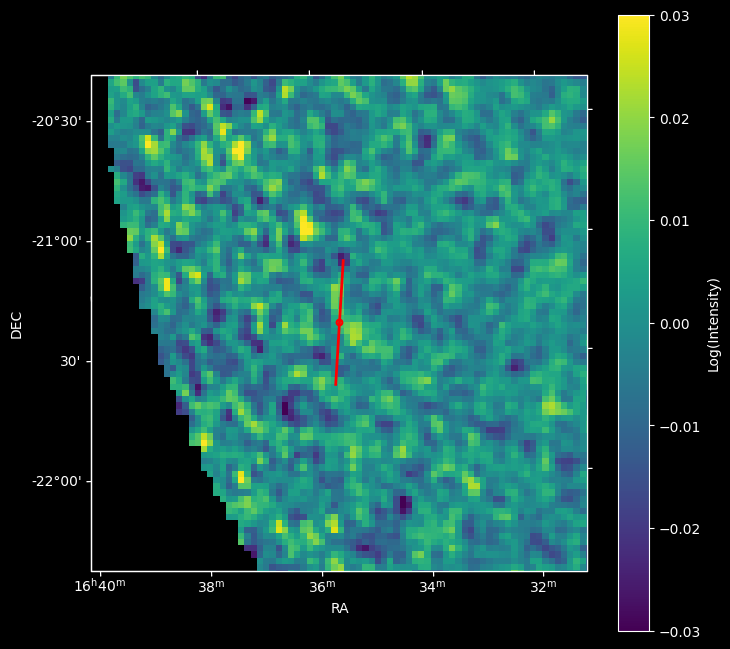

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=wcs)
plt.style.use('dark_background')

lower_limit = -0.03 # np.nanmin(j_img)
upper_limit = 0.03 # np.nanmax(j_img)
im = ax.imshow(j_img, cmap='viridis', origin='lower', aspect='equal', vmin=lower_limit, vmax=upper_limit)

circle = Circle((j_x, j_y), radius=radius_pix, edgecolor='red', facecolor='none', linewidth=1.5)
ax.add_patch(circle)

ax.plot([x1, x2], [y1, y2], color='r', linewidth=2, label="Rotation Axis")


ax.set_xlabel('RA')
ax.set_ylabel('DEC')
cbar = plt.colorbar(im, ax=ax, label="Log(Intensity)")
plt.xlim(j_x - 40, j_x + 40)
plt.ylim(j_y - 40, j_y + 40)

In [6]:
# Make sure Jupiter position is correct
obsdate = jdates[obs_date_idx]
obsdate = Time(obsdate, format='datetime').mjd
print(j_coord)
print()

from astroquery.jplhorizons import Horizons

jupiter = Horizons(id='599', location='@0',epochs=obsdate) 
eph = jupiter.ephemerides()

ra_values = eph['RA']
dec_values = eph['DEC'] 
datetime_values = eph['datetime_jd']
print(eph[['datetime_str', 'RA', 'DEC']]) # slight difference due to parallax correction

<SkyCoord (ICRS): (ra, dec) in deg
    (248.89341996, -21.36988627)>

      datetime_str           RA       DEC   
          ---               deg       deg   
------------------------ --------- ---------
2019-Feb-20 06:43:12.403 248.89145 -21.36091


In [14]:
# How much does Jupiter move in the sky during the observation?
from astroquery.jplhorizons import Horizons

jupiter_start = Horizons(id='599', location='@0',epochs=obsdate) 
eph_start = jupiter.ephemerides()

ra_values_start = eph_start['RA']
dec_values_start = eph_start['DEC'] 
datetime_values_start = eph_start['datetime_jd']
print(eph_start[['datetime_str', 'RA', 'DEC']])

avg_duration = 3 # ks

jupiter_end = Horizons(id='599', location='@0',epochs=obsdate + avg_duration * 1000 / 3600 / 24) # convert ks to days
eph_end = jupiter_end.ephemerides()
ra_values_end = eph_end['RA']
dec_values_end = eph_end['DEC']
datetime_values_end = eph_end['datetime_jd']
print(eph_end[['datetime_str', 'RA', 'DEC']])

# Seperation
from astropy.coordinates import SkyCoord
start_coord = SkyCoord(ra=ra_values_start, dec=dec_values_start, unit='deg')
end_coord = SkyCoord(ra=ra_values_end, dec=dec_values_end, unit='deg')
separation = start_coord.separation(end_coord).arcsec
print(f"Jupiter moves {separation[0]:.2f} arcseconds in the sky during the observation.")

      datetime_str           RA       DEC   
          ---               deg       deg   
------------------------ --------- ---------
2019-Feb-20 06:43:12.403 248.89145 -21.36091
      datetime_str           RA       DEC   
          ---               deg       deg   
------------------------ --------- ---------
2019-Feb-20 07:33:12.403 248.89436 -21.36135
Jupiter moves 9.88 arcseconds in the sky during the observation.
